In [30]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import torch 
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
import wandb
import argparse 
import importlib.util
import inspect
import random

from src.models.models_util import CESM_Dataset
from src.models.models import UNetRes3
from src.utils import util_cesm
from src import config_cesm
from src.models.losses import WeightedMSELoss
import src.config as config_era5

reference_grid = util_cesm.generate_sps_grid()


### Regrid obs

In [1]:
import xarray as xr
import xesmf as xe
import os
import numpy as np 
import pandas as pd 
import argparse 

from src.utils import util_cesm
from src import config_cesm
import src.config as config_era5


In [2]:
cesm_to_era5_varnames = {
    "temp": "sea_surface_temperature",
    "icefrac": "sea_ice_cover",
    "psl": "mean_sea_level_pressure",
    "geopotential": "geopotential_500hPa"
}

cesm_to_era5_short_varnames = {
    "temp": "sst",
    "icefrac": "siconc",
    "psl": "msl",
    "geopotential": "z"
}

def transform_obs_to_cesm_format(var_name, output_grid, savedir): 
    os.makedirs(savedir, exist_ok=True)
    savepath = os.path.join(savedir, f"{var_name}_obs.nc")
    if (os.path.exists(savepath)): return 

    ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/{cesm_to_era5_varnames[var_name]}.nc")).sel(latitude=slice(-30,-90))
    weight_file = f'{config_cesm.DATA_DIRECTORY}/cesm_lens/grids/era5_small_to_sps_bilinear_regridding_weights.nc'
    
    if os.path.exists(weight_file):
        regridder = xe.Regridder(ds, output_grid, 'bilinear', weights=weight_file, 
                                ignore_degenerate=True, reuse_weights=True, periodic=True)
    else:
        regridder = xe.Regridder(ds, output_grid, 'bilinear', filename=weight_file, 
                                ignore_degenerate=True, reuse_weights=False, periodic=True)
    ds_regridded = regridder(ds)
    ds_regridded = ds_regridded.sel(expver=1).combine_first(ds_regridded.sel(expver=5))

    # rename variable
    ds_regridded = ds_regridded.rename({cesm_to_era5_short_varnames[var_name]: var_name})

    # save
    ds_regridded.to_netcdf(savepath)

In [4]:
sps_grid = util_cesm.generate_sps_grid()

for var_name in ["temp", "psl", "icefrac", "geopotential"]:
    print(f"transforming {var_name}")
    transform_obs_to_cesm_format(var_name, sps_grid, os.path.join(config_cesm.DATA_DIRECTORY, "ERA5/cesm_format"))

transforming temp
transforming psl
transforming icefrac
transforming geopotential


### Test normalization
This is a temporary thing

In [14]:
xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/icefrac_obs.nc"))

<xarray.Dataset> Size: 29MB
Dimensions:  (time: 558, y: 80, x: 80)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1978-01-01 1978-02-01 ... 2024-06-01
  * x        (x) float64 640B -4.208e+06 -4.101e+06 ... 4.101e+06 4.208e+06
  * y        (y) float64 640B -4.208e+06 -4.101e+06 ... 4.101e+06 4.208e+06
Data variables:
    icefrac  (time, y, x) float64 29MB ...
Attributes:
    regrid_method:  bilinear

In [98]:
import src.experiment_configs.config_simple_plus_psl as config
import pandas as pd 

data_split_name = "simple_plus_psl" 
data_split_settings = config.DATA_SPLIT_SETTINGS
max_lead_months = 6

normalized_data = []
for var_name in ["temp"]:
    if config.INPUT_CONFIG[var_name]['include'] and config.INPUT_CONFIG[var_name]['norm']:
        max_lag_months = config.INPUT_CONFIG[var_name]['lag']
        merged_ds = xr.open_dataset(os.path.join(config_cesm.RAW_DATA_DIRECTORY, f"{var_name}_combined.nc"))
        cesm_da = merged_ds[var_name]

        divide_by_stdev = config.INPUT_CONFIG[var_name]['divide_by_stdev']

        # Load the observational data
        ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/{var_name}_obs.nc"))
        obs_da = ds[var_name] 

        # convert SST from K to C 
        if var_name == "temp":
            obs_da -= 273.15 

        # Compute the normalization statistics over the CESM dataset
        # this normalization is over the whole spatiotemporal domain 
        if data_split_settings["split_by"] == "time": 
            all_times = util_cesm.get_start_prediction_months(data_split_settings)

            # all_times gives all time coordinates that are accessed, given variable leads and lags
            all_times = pd.date_range(all_times[0] - pd.DateOffset(months=max_lag_months), 
                                    all_times[-1] + pd.DateOffset(months=max_lead_months-1),
                                    freq="MS")        
            cesm_da = cesm_da.sel(time=all_times, member_id=data_split_settings["member_ids"]) 
            da_train_subset = cesm_da.sel(time=data_split_settings["train"])

        elif data_split_settings["split_by"] == "ensemble_member": 
            all_member_ids = data_split_settings["train"] + data_split_settings["val"] + data_split_settings["test"]
            
            all_times = data_split_settings["time_range"]
            all_times = pd.date_range(all_times[0] - pd.DateOffset(months=max_lag_months), 
                                    all_times[-1] + pd.DateOffset(months=max_lead_months-1),
                                    freq="MS") 
            cesm_da = cesm_da.sel(member_id=all_member_ids, time=all_times) 
            da_train_subset = cesm_da.sel(member_id=data_split_settings["train"])
        
        # monthly_means = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
        #     data_split_name, f"{var_name}_mean.nc"))

        monthly_means = da_train_subset.groupby('time.month').mean(("time","x","y","member_id"))
        monthly_stdev = da_train_subset.groupby('time.month').std(("time","x","y","member_id"))

        # normalize
        months = obs_da['time'].dt.month

        if divide_by_stdev: 
            normalized_da = (obs_da - monthly_means.sel(month=months)) / monthly_stdev.sel(month=months)
            # monthly_stdevs = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
            #     data_split_name, f"{var_name}_stdev.nc"))
        
            # normalized_da = xr.apply_ufunc(
            #     util_cesm.normalize,
            #     da,
            #     monthly_means.sel(month=months),
            #     monthly_stdevs.sel(month=months),
            #     var_name,
            #     output_dtypes=[da.dtype],
            #     dask="allowed"
            # )
        else: 
            normalized_da = obs_da - monthly_means.sel(month=months)
        
        # normalized_data.append(normalized_da)


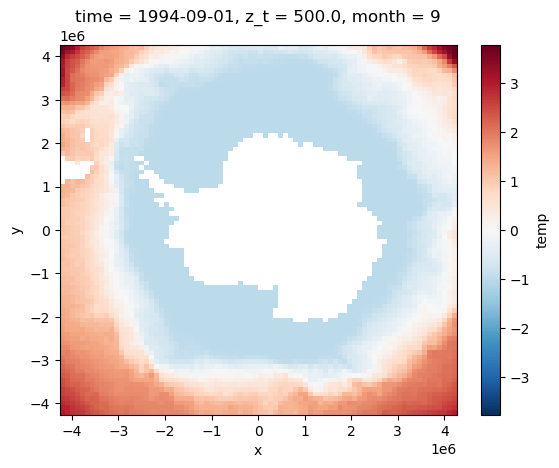

In [103]:
normalized_da.isel(time=200).plot()

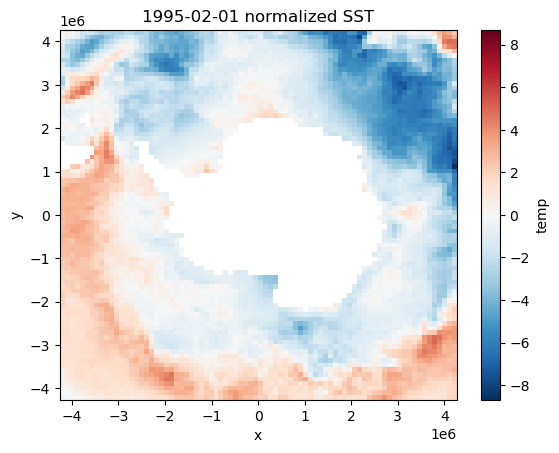

In [90]:
normalized_da.isel(time=205).temp.plot()
plt.title("1995-02-01 normalized SST")
plt.savefig("figures/known_issues/distribution_shift_sst_example2.jpg", dpi=300, bbox_inches='tight')

In [12]:
ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/temp_obs.nc"))
da = ds["temp"] 

# convert SST from K to C 
da -= 273.15 

obs_means = da.groupby("time.month").mean("time")
obs_stdev = da.groupby("time.month").std("time")

data_split_name = "simple_plus_psl" 

cesm_means = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
    data_split_name, f"temp_mean.nc"))["temp"]
 
cesm_stdevs = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
    data_split_name, f"temp_stdev.nc"))["temp"]


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda

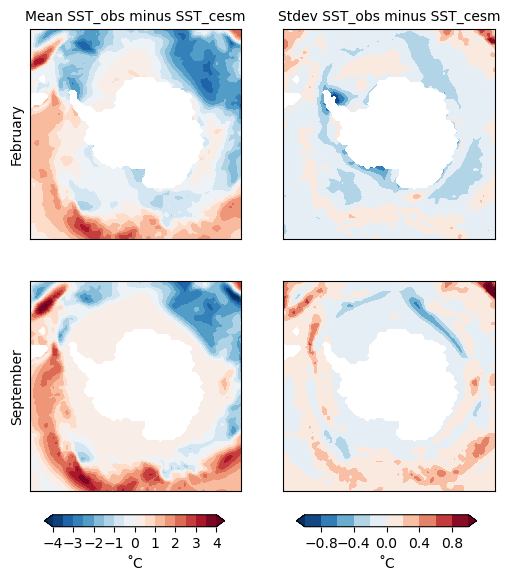

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True)

axs[0,0].contourf(obs_means.sel(month=2) - cesm_means.sel(month=2), cmap="RdBu_r", levels=np.arange(-4, 4.5, 0.5))
cax = axs[1,0].contourf(obs_means.sel(month=9) - cesm_means.sel(month=9), cmap="RdBu_r", levels=np.arange(-4, 4.5, 0.5), extend='both')
axs[0,0].set_ylabel("February")
axs[0,0].set_title("Mean SST_obs minus SST_cesm", fontsize=10)
axs[0,1].set_title("Stdev SST_obs minus SST_cesm", fontsize=10)
axs[0,0].set_yticks([])
axs[0,0].set_xticks([])

axs[0,1].contourf(obs_stdev.sel(month=2) - cesm_stdevs.sel(month=2), cmap="RdBu_r", levels=np.arange(-1, 1.2, 0.2))
axs[1,0].set_ylabel("September")

cax2 = axs[1,1].contourf(obs_stdev.sel(month=9) - cesm_stdevs.sel(month=9), cmap="RdBu_r", levels=np.arange(-1, 1.2, 0.2), extend='both')

cbar_ax = fig.add_axes([0.15,0.05, 0.3, 0.02])
cbar_ax2 = fig.add_axes([0.57, 0.05, 0.3, 0.02])
plt.colorbar(cax, cax=cbar_ax, label=r'˚C', orientation='horizontal', extend="both")
plt.colorbar(cax2, cax=cbar_ax2, label=r'˚C', orientation='horizontal')
plt.savefig("figures/known_issues/distribution_shift_sst.jpg", dpi=300, bbox_inches='tight')



### Data loader

In [8]:
import src.experiment_configs.exp1_inputs.input2 as config
ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/icefrac_obs.nc"))
ntime = len(ds.time) - 12 - 6

train_subset = np.arange(0, (7/10) * ntime, dtype=int)
val_subset = np.arange((7/10) * ntime, (8/10) * ntime, dtype=int)
test_subset = np.arange((8/10) * ntime, ntime, dtype=int)

data_split_settings = {
    "train": train_subset,
    "val": val_subset,
    "test": test_subset
}

In [17]:
data_da_dict = {}

for var_name in config.INPUT_CONFIG.keys(): 
    if config.INPUT_CONFIG[var_name]['include'] and config.INPUT_CONFIG[var_name]['norm']:
        max_lag_months = config.INPUT_CONFIG[var_name]['lag']
        divide_by_stdev = config.INPUT_CONFIG[var_name]['divide_by_stdev']

        # Load the observational data
        ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/{var_name}_obs.nc"))
        obs_da = ds[var_name] 

        da_train_subset = obs_da[np.concatenate((np.arange(12, dtype=int), train_subset + int(12)))]
        monthly_means = da_train_subset.groupby('time.month').mean(("time"))
        monthly_stdev = da_train_subset.groupby('time.month').std(("time"))

        # normalize
        months = obs_da['time'].dt.month

        if divide_by_stdev: 
            normalized_da = (obs_da - monthly_means.sel(month=months)) / monthly_stdev.sel(month=months)
        else: 
            normalized_da = obs_da - monthly_means.sel(month=months)
        
        data_da_dict[var_name] = normalized_da.drop_vars("month")


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/groups/earlew/yuchen/miniconda

In [19]:
def get_obs_start_prediction_months(data_da_dict, data_split_settings):
    max_lag = 12
    first_month = data_da_dict["icefrac"].time[max_lag].item()
    last_month = data_da_dict["icefrac"].time[-config.MAX_LEAD_MONTHS].item()
    return pd.date_range(first_month, last_month, freq="MS")


def save_obs_inputs(input_config, save_path, data_da_dict, data_split_settings):
    """
    Writes a model-ready input file (.nc) for each ensemble member to save_path

    Param:
        (dict)      input_config
        (string)    save_path
    """

    # get some auxiliary data
    x_coords = data_da_dict["icefrac"].x.data
    y_coords = data_da_dict["icefrac"].y.data
    land_mask = np.isnan(data_da_dict["icefrac"].isel(time=0)).data
    land_mask = np.transpose(land_mask.reshape(1, 80, 80), [0, 2, 1]) # for some reason, x and y get switched

    start_prediction_months = get_obs_start_prediction_months(data_da_dict, data_split_settings)
    save_name = os.path.join(save_path, f"inputs_obs.nc")
    if os.path.exists(save_name):
       return

    da_list = []
    for start_prediction_month in start_prediction_months:
        time_da_list = []
        for input_var, input_var_params in input_config.items():
            if not input_var_params["include"]: 
                continue 
            
            if not input_var_params["auxiliary"]:
                prediction_input_months = pd.date_range(start_prediction_month - pd.DateOffset(months=input_var_params["lag"]), 
                                                        start_prediction_month - pd.DateOffset(months=1), freq="MS")

                input_data = data_da_dict[input_var].sel(time=prediction_input_months)

                # mask out NaN values
                input_data = input_data.fillna(0)

                # rename the time coordinate to channel 
                lag = input_var_params["lag"]
                input_data = input_data.assign_coords(time=[f"{input_var}_lag{lag+1-i}" for i in range(1, lag+1)])
                input_data = input_data.rename({"time": "channel"})
            else:
                if input_var == "cosine_of_init_month":
                    input_data = xr.DataArray(
                        np.full((1, 80, 80), np.cos(2 * np.pi * start_prediction_month.month / 12)),
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                elif input_var == "sine_of_init_month":
                    input_data = xr.DataArray(
                        np.full((1, 80, 80), np.sin(2 * np.pi * start_prediction_month.month / 12)),
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                elif input_var == "land_mask": 
                    input_data = xr.DataArray(
                        land_mask, 
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                else: 
                    raise NotImplementedError()

            # add a coordinate to denote the start prediction month (time origin)
            input_data = input_data.assign_coords(start_prediction_month=start_prediction_month)

            time_da_list.append(input_data)

        da_list.append(xr.concat(time_da_list, dim="channel", coords='minimal', compat='override'))

    da_merged = xr.concat(da_list, dim="start_prediction_month", coords="minimal", compat='override')

    # rechunk
    da_merged = da_merged.chunk(chunks={"start_prediction_month":12, "channel":-1})

    # clean up singleton dimensions
    if "z_t" in da_merged.dims: 
        da_merged = da_merged.drop_vars("z_t")
    if "lev" in da_merged.dims:
        da_merged = da_merged.drop_vars("lev")


    print("done! Saving...")
    da_merged.to_dataset(name="data").to_netcdf(save_name)
    da_merged.close()



In [20]:

def save_obs_targets(input_da_dict, input_config, target_config, 
                    save_path, max_lead_months, data_split_settings):
    """
    Writes a model-ready targets file (.nc) for each ensemble member to save_path
    
    Param:
        (dict)      input_config
        (dict)      target_config
        (string)    save_path
        (int)       max_lead_months
        (dict)      data_split_settings
    """

    if not target_config["predict_anom"]:
        raise NotImplementedError()
    else:
        da = input_da_dict["icefrac"]

    start_prediction_months = get_obs_start_prediction_months(input_da_dict, data_split_settings)
    save_name = os.path.join(save_path, f"targets_obs.nc")
    if os.path.exists(save_name):
        return

    time_da_list = []

    for start_prediction_month in start_prediction_months:
        prediction_target_months = pd.date_range(start_prediction_month, 
                                                start_prediction_month + pd.DateOffset(months=max_lead_months-1), 
                                                freq="MS")
        
        target_data = da.sel(time=prediction_target_months)

        # mask out nans
        target_data = target_data.fillna(0)

        target_data = target_data.assign_coords(time=np.arange(1,7))
        target_data = target_data.rename({"time": "lead_time"}) 

        # add a coordinate to denote the start prediction month (time origin)
        target_data = target_data.assign_coords(start_prediction_month=start_prediction_month)

        time_da_list.append(target_data)

    da_merged = xr.concat(time_da_list, dim="start_prediction_month", coords='minimal', compat='override')

    da_merged = da_merged.chunk(chunks={"start_prediction_month":12, "lead_time":-1})
    
    da_merged.to_dataset(name="data").to_netcdf(save_name)
    da_merged.close()


In [21]:
save_path = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config.DATA_CONFIG_NAME)

save_obs_inputs(config.INPUT_CONFIG, save_path, data_da_dict, data_split_settings)

save_obs_targets(data_da_dict, config.INPUT_CONFIG, config.TARGET_CONFIG, 
                save_path, 6, data_split_settings)


In [22]:
save_path = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config.DATA_CONFIG_NAME)

inputs_da = xr.open_dataset(os.path.join(save_path, "inputs_obs.nc")).data
targets_da = xr.open_dataset(os.path.join(save_path, "targets_obs.nc")).data


class Obs_Dataset(torch.utils.data.Dataset):
    def __init__(self, split, data_config_name, data_split_settings):
        self.data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", data_config_name)
        self.split = split

        # Open and keep datasets in memory (or use .load() to load them immediately)
        self.inputs = xr.open_dataset(os.path.join(self.data_dir, "inputs_obs.nc")).data
        self.targets = xr.open_dataset(os.path.join(self.data_dir, "targets_obs.nc")).data

        # Build a global index of samples
        time_values = self.inputs["start_prediction_month"].values
        self.samples = [(time_values[start_idx], int(start_idx)) for start_idx in data_split_settings[split]]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        start_prediction_month, start_idx = self.samples[idx]

        input_sample = self.inputs.isel(start_prediction_month=start_idx).load().values.copy()
        target_sample = self.targets.isel(start_prediction_month=start_idx).load().values.copy()

        max_lead_months = target_sample.shape[0]
        start_prediction_months = pd.date_range(
            start_prediction_month,
            start_prediction_month + pd.DateOffset(months=max_lead_months - 1),
            freq="MS"
        )

        time_npy = np.column_stack((start_prediction_months.year, start_prediction_months.month))

        sample = {
            "input": torch.tensor(input_sample, dtype=torch.float32),
            "target": torch.tensor(target_sample, dtype=torch.float32),
            "start_prediction_month": time_npy,
        }

        return sample


In [23]:

train_dataset = Obs_Dataset("train", config.DATA_CONFIG_NAME, data_split_settings)
val_dataset = Obs_Dataset("val", config.DATA_CONFIG_NAME, data_split_settings)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels = util_cesm.get_num_input_channels(config.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config.MAX_LEAD_MONTHS, config.TARGET_CONFIG)

if config.MODEL == "UNetRes3": 
    model = UNetRes3(in_channels=in_channels, 
                    out_channels=out_channels, 
                    predict_anomalies=config.TARGET_CONFIG["predict_anom"]).to(device)
else: 
    raise NotImplementedError(f"Model {config.MODEL} not implemented.")

optimizer = Adam(model.parameters(), lr=0.0005)

if config.LOSS_FUNCTION == "MSE": 
    loss_fn = WeightedMSELoss(device=device, **config.LOSS_FUNCTION_ARGS)

In [24]:
def validate_epoch(model, dataloader, loss_fn, device, epoch, total_epochs):
    model.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}/{total_epochs} [Val]")
    loss_fn_params = inspect.signature(loss_fn.forward).parameters

    with torch.no_grad():
        for batch_idx, batch in progress_bar:
            inputs, targets = batch["input"].to(device), batch["target"].to(device)
            predictions = model(inputs)

            loss_kwargs = {"prediction": predictions, "target": targets}
            if "target_months" in loss_fn_params:
                target_months = batch["start_prediction_month"][:, :, 1].to(device)
                loss_kwargs["target_months"] = target_months

            loss = loss_fn(**loss_kwargs)
            
            epoch_loss += loss.item()
            # Update progress bar with batch loss
            progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    return epoch_loss / len(dataloader)
    
def train_epoch(model, dataloader, optimizer, loss_fn, device, epoch, total_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}/{total_epochs} [Train]")
    loss_fn_params = inspect.signature(loss_fn.forward).parameters

    for _, batch in progress_bar:
        inputs, targets = batch["input"].to(device), batch["target"].to(device)
        
        optimizer.zero_grad()
        predictions = model(inputs)

        loss_kwargs = {"prediction": predictions, "target": targets}
        if "target_months" in loss_fn_params:
            # batch["start_prediction_month"] is of shape (batch_size, max_lead_months, 2)
            target_months = batch["start_prediction_month"][:, :, 1].to(device)
            loss_kwargs["target_months"] = target_months

        loss = loss_fn(**loss_kwargs)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # Update progress bar with batch loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    return epoch_loss / len(dataloader)


In [80]:
# train model 
start_epoch = 0
total_epochs = 20
for epoch in range(start_epoch, total_epochs + 1):
    train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device, epoch, total_epochs)
    val_loss = validate_epoch(model, val_dataloader, loss_fn, device, epoch, total_epochs)

    # Log metrics to WandB
    # wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

    # Save a checkpoint
    # file_name = f"{config.MODEL}_{config.EXPERIMENT_NAME}_member_{ensemble_id}_epoch_{epoch}.pth"
    # checkpoint_path = os.path.join(save_dir, file_name)
    # if epoch % config.CHECKPOINT_INTERVAL == 0:
    #     torch.save({
    #         "epoch": epoch,
    #         "model_state_dict": model.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict(),
    #     }, checkpoint_path)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 0/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 24.95it/s, Batch Loss=0.0147]

Epoch 0 - Train Loss: 0.0077, Val Loss: 0.0110



Epoch 1/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 26.08it/s, Batch Loss=0.0159] 

Epoch 1 - Train Loss: 0.0075, Val Loss: 0.0110



Epoch 2/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 32.71it/s, Batch Loss=0.0135] 

Epoch 2 - Train Loss: 0.0075, Val Loss: 0.0107



Epoch 3/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 20.45it/s, Batch Loss=0.0147]

Epoch 3 - Train Loss: 0.0073, Val Loss: 0.0110



Epoch 4/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 27.89it/s, Batch Loss=0.0142]

Epoch 4 - Train Loss: 0.0073, Val Loss: 0.0107



Epoch 5/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 24.24it/s, Batch Loss=0.0153]

Epoch 5 - Train Loss: 0.0072, Val Loss: 0.0111



Epoch 6/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 20.03it/s, Batch Loss=0.0161]

Epoch 6 - Train Loss: 0.0071, Val Loss: 0.0111



Epoch 7/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 23.95it/s, Batch Loss=0.0155] 

Epoch 7 - Train Loss: 0.0071, Val Loss: 0.0110



Epoch 8/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 22.91it/s, Batch Loss=0.0151]

Epoch 8 - Train Loss: 0.0069, Val Loss: 0.0111



Epoch 9/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 28.74it/s, Batch Loss=0.0162] 

Epoch 9 - Train Loss: 0.0068, Val Loss: 0.0112



Epoch 10/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 26.95it/s, Batch Loss=0.0143] 

Epoch 10 - Train Loss: 0.0068, Val Loss: 0.0110



Epoch 11/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 26.20it/s, Batch Loss=0.0152]

Epoch 11 - Train Loss: 0.0066, Val Loss: 0.0110



Epoch 12/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 30.84it/s, Batch Loss=0.0154]

Epoch 12 - Train Loss: 0.0064, Val Loss: 0.0115



Epoch 13/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 26.14it/s, Batch Loss=0.0131]

Epoch 13 - Train Loss: 0.0064, Val Loss: 0.0109



Epoch 14/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 27.33it/s, Batch Loss=0.0153] 

Epoch 14 - Train Loss: 0.0063, Val Loss: 0.0115



Epoch 15/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 25.91it/s, Batch Loss=0.0141]

Epoch 15 - Train Loss: 0.0061, Val Loss: 0.0119



Epoch 16/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 20.50it/s, Batch Loss=0.0137]

Epoch 16 - Train Loss: 0.0060, Val Loss: 0.0112



Epoch 17/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 21.97it/s, Batch Loss=0.0138]

Epoch 17 - Train Loss: 0.0059, Val Loss: 0.0110



Epoch 18/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 22.00it/s, Batch Loss=0.0141]

Epoch 18 - Train Loss: 0.0058, Val Loss: 0.0111



Epoch 19/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 26.57it/s, Batch Loss=0.0153] 

Epoch 19 - Train Loss: 0.0057, Val Loss: 0.0120



Epoch 20/20 [Val]: 100%|██████████| 14/14 [00:00<00:00, 22.91it/s, Batch Loss=0.0145]

Epoch 20 - Train Loss: 0.0056, Val Loss: 0.0115


In [81]:
test_dataset = Obs_Dataset("test", config.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

model.eval()

time_coords = inputs_da.start_prediction_month[data_split_settings["test"]]
channels, x_dim, y_dim = config.MAX_LEAD_MONTHS, 80, 80

ds_pred = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

ds_truth = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

# Populate the Dataset with predictions
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating", unit="sample")): 
        inputs = batch["input"].to(device)
        targets = batch["target"]
        predictions = model(inputs).cpu().numpy()  # Move predictions to CPU
        
        # since batch size = 1, get the only sample in the batch
        predictions = predictions[0]

        # Extract metadata
        start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0,0]
        start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)

        # Find the appropriate indices
        time_idx = list(time_coords).index(start_prediction_month)

        ds_pred["icefrac"][time_idx, :, :, :] = predictions
        ds_truth["icefrac"][time_idx, :, :, :] = targets[0]

Evaluating: 100%|██████████| 108/108 [00:04<00:00, 22.70sample/s]


In [87]:
ds_truth.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_truth.nc")
ds_pred.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_pred_input2_nopretrain.nc")

In [108]:
pred_anom = ds_pred.icefrac
truth_anom = ds_truth.icefrac

def calc_acc(pred_anom, truth_anom):
    dim = ("x", "y")
    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))
    acc = acc.groupby("start_prediction_month.month").mean("start_prediction_month")

    acc = xr.concat(
        [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
        dim="lead_time"
    )

    return acc

In [94]:
checkpoint_path = "/scratch/users/yucli/sicpred_models/exp2_vol4/UNetRes3_exp2_vol4_member_0_epoch_10.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

model_pt = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config.TARGET_CONFIG["predict_anom"]).to(device)
model_pt.load_state_dict(checkpoint["model_state_dict"])

optimizer = Adam(model_pt.parameters(), lr=0.0005)

if config.LOSS_FUNCTION == "MSE": 
    loss_fn = WeightedMSELoss(device=device, **config.LOSS_FUNCTION_ARGS)

In [107]:
test_dataset = Obs_Dataset("test", config.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

model_pt.eval()

time_coords = inputs_da.start_prediction_month[data_split_settings["test"]]
channels, x_dim, y_dim = config.MAX_LEAD_MONTHS, 80, 80

ds_pred = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

ds_truth = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

# Populate the Dataset with predictions
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating", unit="sample")): 
        inputs = batch["input"].to(device)
        targets = batch["target"]
        predictions = model_pt(inputs).cpu().numpy()  # Move predictions to CPU
        
        # since batch size = 1, get the only sample in the batch
        predictions = predictions[0]

        # Extract metadata
        start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0,0]
        start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)

        # Find the appropriate indices
        time_idx = list(time_coords).index(start_prediction_month)

        ds_pred["icefrac"][time_idx, :, :, :] = predictions
        ds_truth["icefrac"][time_idx, :, :, :] = targets[0]

ds_pred.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_pred_input2_pretrain_nofinetune.nc")

Evaluating: 100%|██████████| 108/108 [00:05<00:00, 20.36sample/s]


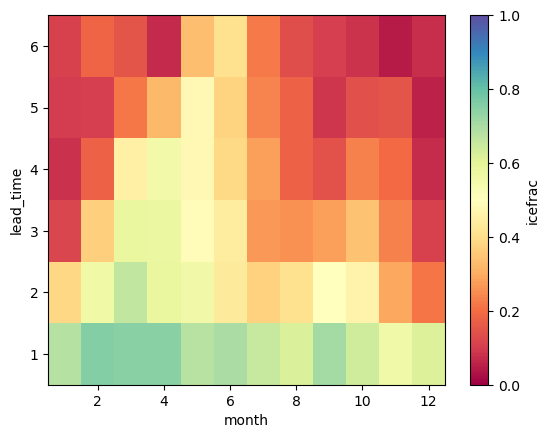

In [111]:
calc_acc(ds_pred.icefrac, ds_truth.icefrac).plot(vmin=0, vmax=1, cmap="Spectral")

In [112]:
# train model 
start_epoch = 0
total_epochs = 10
for epoch in range(start_epoch, total_epochs + 1):
    train_loss = train_epoch(model_pt, train_dataloader, optimizer, loss_fn, device, epoch, total_epochs)
    val_loss = validate_epoch(model_pt, val_dataloader, loss_fn, device, epoch, total_epochs)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 0/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 23.93it/s, Batch Loss=0.012] 

Epoch 0 - Train Loss: 0.0073, Val Loss: 0.0096



Epoch 1/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 21.63it/s, Batch Loss=0.0133]

Epoch 1 - Train Loss: 0.0066, Val Loss: 0.0098



Epoch 2/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 21.41it/s, Batch Loss=0.0119] 

Epoch 2 - Train Loss: 0.0060, Val Loss: 0.0098



Epoch 3/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 25.96it/s, Batch Loss=0.0127] 

Epoch 3 - Train Loss: 0.0055, Val Loss: 0.0101



Epoch 4/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 28.00it/s, Batch Loss=0.0117]

Epoch 4 - Train Loss: 0.0051, Val Loss: 0.0100



Epoch 5/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 27.63it/s, Batch Loss=0.0119]

Epoch 5 - Train Loss: 0.0048, Val Loss: 0.0100



Epoch 6/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 42.11it/s, Batch Loss=0.0131]

Epoch 6 - Train Loss: 0.0045, Val Loss: 0.0103



Epoch 7/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 27.65it/s, Batch Loss=0.0132]

Epoch 7 - Train Loss: 0.0043, Val Loss: 0.0103



Epoch 8/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 27.82it/s, Batch Loss=0.0122]

Epoch 8 - Train Loss: 0.0041, Val Loss: 0.0102



Epoch 9/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 29.02it/s, Batch Loss=0.0143] 

Epoch 9 - Train Loss: 0.0039, Val Loss: 0.0107



Epoch 10/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 33.02it/s, Batch Loss=0.0127] 

Epoch 10 - Train Loss: 0.0038, Val Loss: 0.0105


In [113]:
model_pt.eval()

ds_pred = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

# Populate the Dataset with predictions
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating", unit="sample")): 
        inputs = batch["input"].to(device)
        targets = batch["target"]
        predictions = model_pt(inputs).cpu().numpy()  # Move predictions to CPU
        
        # since batch size = 1, get the only sample in the batch
        predictions = predictions[0]

        # Extract metadata
        start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0,0]
        start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)

        # Find the appropriate indices
        time_idx = list(time_coords).index(start_prediction_month)

        ds_pred["icefrac"][time_idx, :, :, :] = predictions

ds_pred.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_pred_input2_pretrain_finetune_10epochs.nc")

Evaluating: 100%|██████████| 108/108 [00:05<00:00, 20.89sample/s]


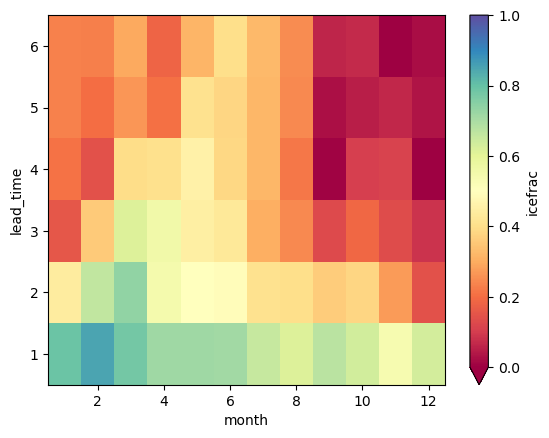

In [115]:
calc_acc(ds_pred.icefrac, ds_truth.icefrac).plot(vmin=0, vmax=1, cmap="Spectral")